# About

This Jupyter notebook contains the beginnings of our analysis code for the [PCAWG](https://dcc.icgc.org/pcawg) infrastructure paper.  This paper describes our efforts to run the core analysis for the project, namely the alignment workflow with 3 variant calling workflows.  We built various infrastructure components that let us do this in a distributed way across many (14) cloud and HPC environments.

The main text of the paper is currently in a private Google document.  This notebook will be used (maybe) to generate our figures if I can figure out how to program in Python!


In [7]:
%matplotlib inline

BWA Timing Histogram


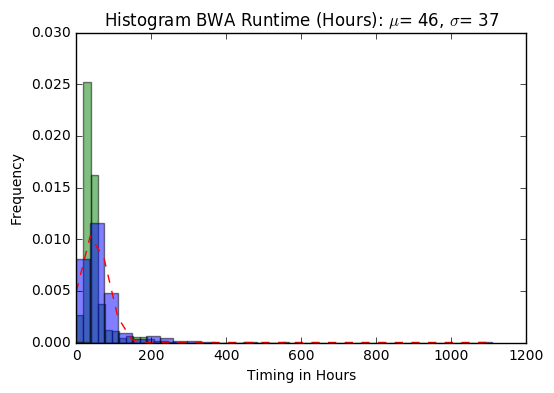

In [8]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import gzip
from io import StringIO
from io import BytesIO
import urllib
import json
import statistics
import traceback
import sys

# file content
file_content = ""

# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz
# http://pancancer.info/gnos_metadata/latest/donor_p_151215020209.jsonl.gz
# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz
# small
# request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz')
# large
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content = f.read()

# BWA Analysis
bwa_normal_timing_list = []
bwa_tumor_timing_list = []

for line in file_content.splitlines():
    json_struct = json.loads(line.decode(encoding='UTF-8'))
    #print(json_struct)
    #print(json_struct['normal_specimen'])
    try:
        bwa_normal_timing = 0
        for timing in json_struct['normal_specimen']['alignment']['timing_metrics'] :
            #print(timing['metrics']['bwa_timing_seconds'])
            bwa_normal_timing += timing['metrics']['bwa_timing_seconds']
        #print(bwa_normal_timing)
        bwa_normal_timing_list.append(bwa_normal_timing/60/60)
    except:
        pass
    try:
        bwa_tumor_timing = 0
        for aligned_tumor in json_struct['aligned_tumor_specimens'] :
            for timing in aligned_tumor['alignment']['timing_metrics'] :
                bwa_tumor_timing += timing['metrics']['bwa_timing_seconds']
        #print(bwa_tumor_timing)
        bwa_tumor_timing_list.append(bwa_tumor_timing/60/60)
    except Exception as err:
        pass
    
print("BWA Timing Histogram")
#print(bwa_normal_timing_list)
#print(bwa_tumor_timing_list)

# histogram
mu = statistics.mean(bwa_normal_timing_list) # mean of distribution
sigma = statistics.stdev(bwa_normal_timing_list) # standard deviation of distribution
num_bins = 30
n, bins, patches = plt.hist(bwa_normal_timing_list, num_bins, normed=1, facecolor='green', alpha=0.5)
n, bins, patches = plt.hist(bwa_tumor_timing_list, num_bins, normed=1, facecolor='blue', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Timing in Hours')
plt.ylabel('Frequency')
plt.title(r"Histogram BWA Runtime (Hours): $\mu$=%3d, $\sigma$=%3d" % (mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import gzip
from io import StringIO
from io import BytesIO
import urllib
import json
import statistics
import traceback
import sys

# file content
file_content = ""

# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz
# http://pancancer.info/gnos_metadata/latest/donor_p_151215020209.jsonl.gz
# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz
# small
#request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz')
# large
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content = f.read()

# Sanger Analysis
timing_list = []

for line in file_content.splitlines():
    json_struct = json.loads(line.decode(encoding='UTF-8'))
    #print(json_struct)
    print(json_struct['variant_calling_results']['sanger_variant_calling']['workflow_details']['variant_timing_metrics'])
    exit()
    try:
        sanger_timing = 0
        for timing in json_struct['variant_calling_results']['sanger_variant_calling']['workflow_details']['variant_timing_metrics'] :
            #print(timing['metrics']['bwa_timing_seconds'])
            sanger_timing += timing['workflow']['Wall_s']
        #print(bwa_normal_timing)
        timing_list.append(sanger_timing/60/60)
    except:
        pass
    
print("Sanger Somatic Variant Timing Histogram")
#print(bwa_normal_timing_list)
#print(bwa_tumor_timing_list)

# histogram
mu = statistics.mean(timing_list) # mean of distribution
sigma = statistics.stdev(timing_list) # standard deviation of distribution
num_bins = 30
n, bins, patches = plt.hist(timing_list, num_bins, normed=1, facecolor='blue', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Timing in Hours')
plt.ylabel('Frequency')
plt.title(r"Histogram Sanger Runtime (Hours): $\mu$=%3d, $\sigma$=%3d" % (mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

{'workflow_details': {'variant_timing_metrics': {'pairs': {'fc8130e0-a94d-d9d0-e040-11ac0c483262': {'binCounts': {'caller': 'binCounts', 'total_cpu_s': 58705.78, 'max_mem_mb': 198, 'detailed': {'tumour': [{'System_s': '54.90', 'Wall_s': '5393.84', 'User_s': '5252.90', 'Max_kb': '192128'}, {'System_s': '40.92', 'Wall_s': '4228.18', 'User_s': '4124.21', 'Max_kb': '191888'}, {'System_s': '43.81', 'Wall_s': '4455.70', 'User_s': '4349.04', 'Max_kb': '192608'}, {'System_s': '40.97', 'Wall_s': '4193.91', 'User_s': '4091.50', 'Max_kb': '191888'}, {'System_s': '37.27', 'Wall_s': '3850.94', 'User_s': '3757.43', 'Max_kb': '202336'}, {'System_s': '34.43', 'Wall_s': '3473.77', 'User_s': '3390.82', 'Max_kb': '191712'}, {'System_s': '32.61', 'Wall_s': '3230.53', 'User_s': '3158.14', 'Max_kb': '191952'}, {'System_s': '24.86', 'Wall_s': '2497.34', 'User_s': '2440.95', 'Max_kb': '191728'}, {'System_s': '30.37', 'Wall_s': '3038.54', 'User_s': '2960.99', 'Max_kb': '191776'}, {'System_s': '27.39', 'Wall_s'